In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_breast_cancer

In [2]:
df = pd.read_csv("C:/Users/Acer/layeredEnsemble/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot:xlabel='target', ylabel='count'>

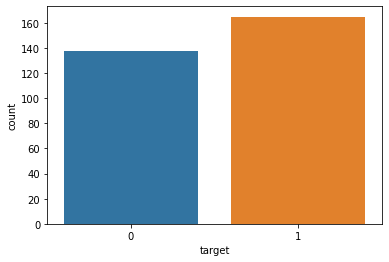

In [6]:
sns.countplot(x = 'target', data=df)

In [7]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [8]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [10]:
#standarize/transform your data such that its distribution will have a mean value 0 and standard deviation of 1 and this is done feature wise.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [13]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [14]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 13.
        self.layer_1 = nn.Linear(13, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=13, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [20]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.60361 | Acc: 68.250
Epoch 002: | Loss: 0.50746 | Acc: 78.750
Epoch 003: | Loss: 0.47279 | Acc: 79.250
Epoch 004: | Loss: 0.39987 | Acc: 83.250
Epoch 005: | Loss: 0.38932 | Acc: 82.500
Epoch 006: | Loss: 0.37528 | Acc: 86.000
Epoch 007: | Loss: 0.33237 | Acc: 84.500
Epoch 008: | Loss: 0.32475 | Acc: 89.500
Epoch 009: | Loss: 0.34346 | Acc: 85.000
Epoch 010: | Loss: 0.33666 | Acc: 85.750
Epoch 011: | Loss: 0.31654 | Acc: 88.250
Epoch 012: | Loss: 0.29044 | Acc: 89.000
Epoch 013: | Loss: 0.26883 | Acc: 92.500
Epoch 014: | Loss: 0.24718 | Acc: 92.000
Epoch 015: | Loss: 0.24397 | Acc: 92.500
Epoch 016: | Loss: 0.26129 | Acc: 92.000
Epoch 017: | Loss: 0.25600 | Acc: 90.750
Epoch 018: | Loss: 0.22980 | Acc: 91.500
Epoch 019: | Loss: 0.24838 | Acc: 91.500
Epoch 020: | Loss: 0.25428 | Acc: 89.500
Epoch 021: | Loss: 0.23578 | Acc: 93.000
Epoch 022: | Loss: 0.19013 | Acc: 95.250
Epoch 023: | Loss: 0.19798 | Acc: 96.000
Epoch 024: | Loss: 0.21612 | Acc: 92.750
Epoch 025: | Los

In [21]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [22]:
confusion_matrix(y_test, y_pred_list)

array([[36,  9],
       [11, 44]], dtype=int64)

In [23]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78        45
           1       0.83      0.80      0.81        55

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

